# Main objective of the analysis

Have you considered building a house? You will probabily need concrete. It consists of three fundamental components: water, cement, and aggregate (e.g. sand, rock, or gravel). This mix can harden into hardy solid-state substance. Before building a house, we should estimate a durability of used materials to avoid a building failure. Thus, we learn from past data how to predict a strength of concrete if composition and age of substance is known.


# Summary of data set

The data set has been downloaded from https://www.kaggle.com/prathamtripathi/regression-with-neural-networking. The data set contains 1030 observations of 9 features. We aim at evaluating a strength of concrete. The variables and their types we use are listed below.

In [1]:
import pandas as pd

data = pd.read_csv("concrete_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [2]:
data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


# Data exploration

To get a better understanding of data, we want to analyse, we examine a distributions of numerical variables.

In [3]:
data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


We observe that variables are on different scales.

In [4]:
data.skew()

Cement                0.509481
Blast Furnace Slag    0.800717
Fly Ash               0.537354
Water                 0.074628
Superplasticizer      0.907203
Coarse Aggregate     -0.040220
Fine Aggregate       -0.253010
Age                   3.269177
Strength              0.416977
dtype: float64

We examine if values follow a normal distribution using D'Agostino test. As the output, we obtain a p-value. If p-value is higher than 0.05, we fail to reject a null hypothesis that a distribution is normally distributed.

In [5]:
from scipy.stats.mstats import normaltest

for feature in data.columns:
    k, p = normaltest(getattr(data, feature).values)
    if p < 0.05:
        print(feature, p)

Cement 3.882119832049044e-14
Blast Furnace Slag 4.3137928491357e-24
Fly Ash 0.0
Superplasticizer 3.459309544852072e-31
Coarse Aggregate 8.454580261325214e-08
Fine Aggregate 0.003713819663715185
Age 1.0714325997785868e-158
Strength 4.937236241653123e-08


As we see, none of the p-values is higher than 0.05. It means that data is not normally distributed.

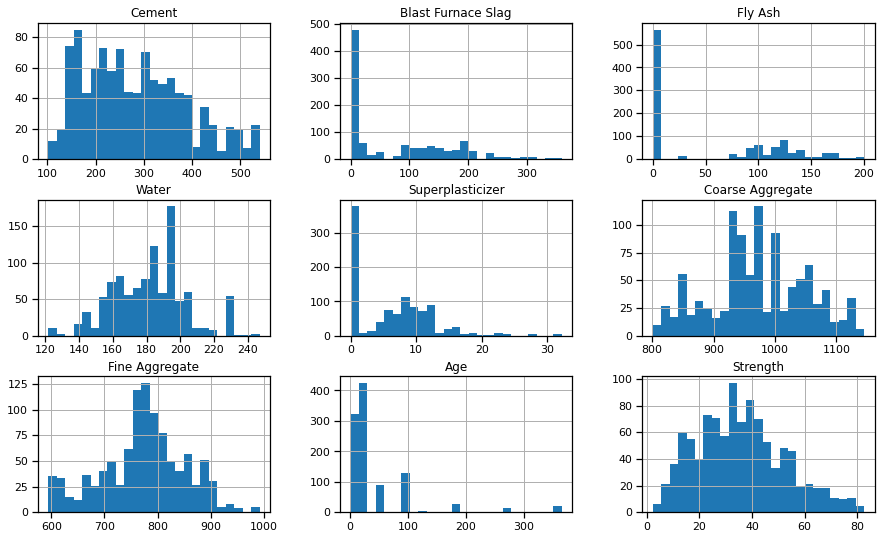

In [6]:
import seaborn as sns
sns.set_context('notebook')

# To create four separate plots, use Pandas `.hist` method
axList = data.hist(bins=25, figsize=(15, 9), layout=(3, 3))

We observe that most variables are not normally distributed. Age is right skew as the data set examines mostly young buildings. Some features, that is blast furnace slag, fly ash, and superplasticizer, are right-skew because they have many zero-values. We can conclude that these ingredients are optional as they are not always in many concrete compositions. 

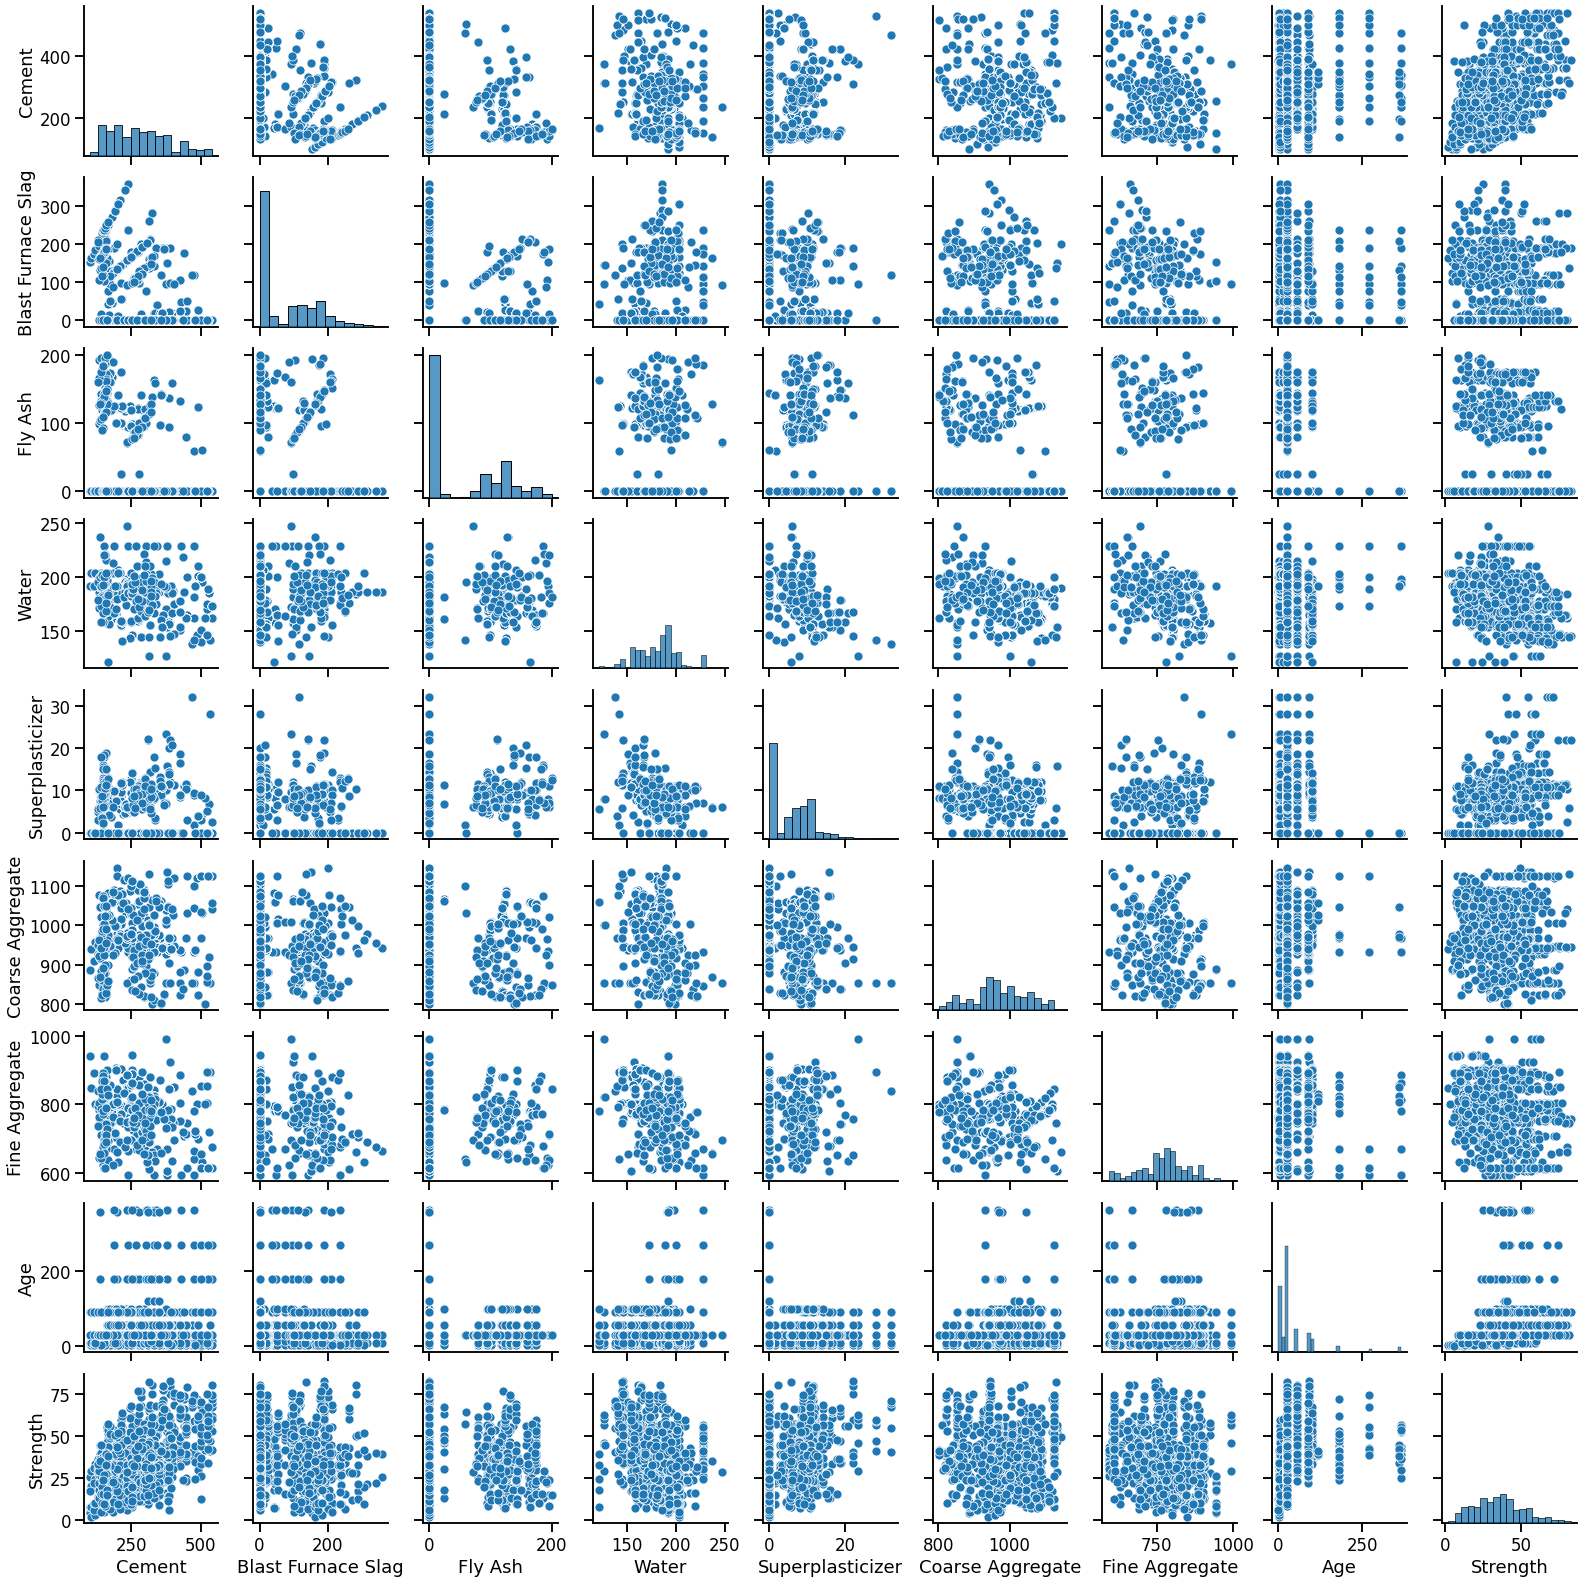

In [7]:
sns.set_context('talk')
sns.pairplot(data)

<AxesSubplot:>

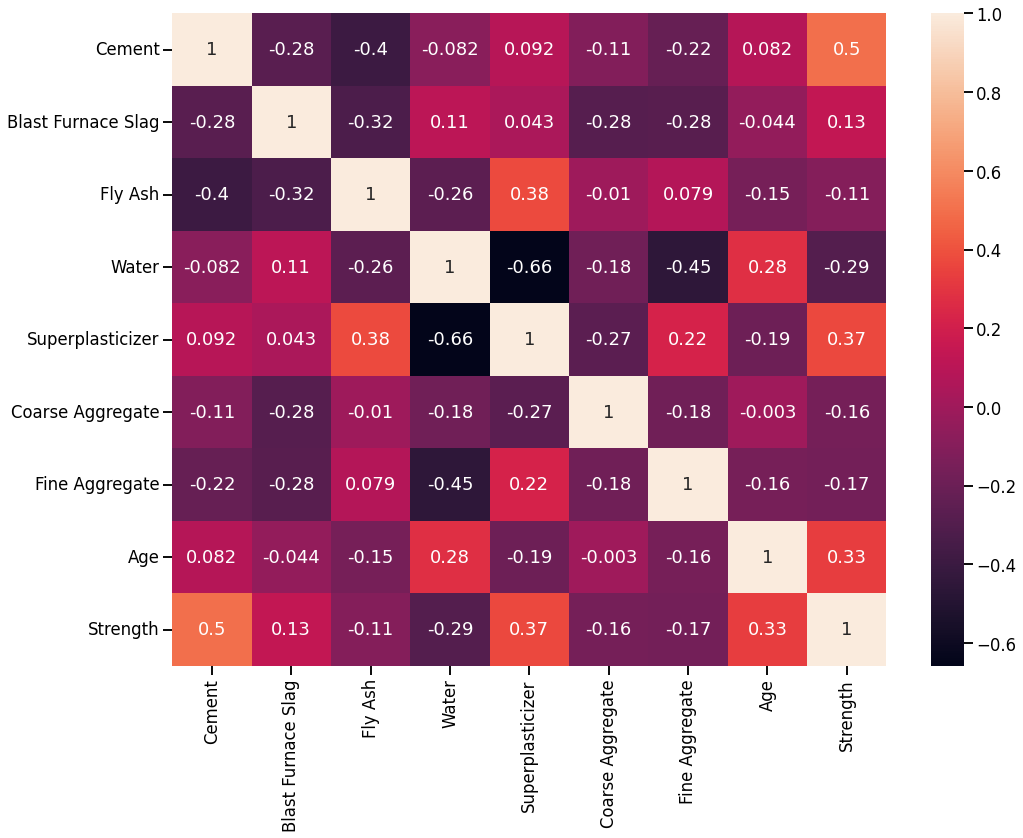

In [8]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(data.corr(), annot=True, ax=ax)

We observe that some independent variables are negatively correlated, as superplasticizer and water, or fine aggregate and water. However, we do not need to worry about dependencies between independent variables, as adding ingredients to mixture is independent. Thus, we should not get a spurious correlation.

# Data preprocessing

## Cleaning
The data set is clear as there are no missing values and no outliers.

## Feature engineering

To include non-linear effects, we include polynomial and interaction features of a second degree. As the result, we have 44 independent variables.

In [9]:
from sklearn.preprocessing import PolynomialFeatures

y = data[["Strength"]]
X = data.drop(labels="Strength", axis=1)

pf = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pd.DataFrame(pf.fit_transform(X), columns = pf.get_feature_names_out())
X_poly

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Cement^2,Cement Blast Furnace Slag,...,Superplasticizer^2,Superplasticizer Coarse Aggregate,Superplasticizer Fine Aggregate,Superplasticizer Age,Coarse Aggregate^2,Coarse Aggregate Fine Aggregate,Coarse Aggregate Age,Fine Aggregate^2,Fine Aggregate Age,Age^2
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,291600.00,0.00,...,6.25,2600.00,1690.00,70.0,1081600.00,703040.00,29120.0,456976.00,18928.0,784.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,291600.00,0.00,...,6.25,2637.50,1690.00,70.0,1113025.00,713180.00,29540.0,456976.00,18928.0,784.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,110556.25,47381.25,...,0.00,0.00,0.00,0.0,868624.00,553608.00,251640.0,352836.00,160380.0,72900.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,110556.25,47381.25,...,0.00,0.00,0.00,0.0,868624.00,553608.00,340180.0,352836.00,216810.0,133225.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,39441.96,26294.64,...,0.00,0.00,0.00,0.0,957266.56,807669.20,352224.0,681450.25,297180.0,129600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28.0,76396.96,32062.40,...,79.21,7743.89,6837.87,249.2,757074.01,668497.83,24362.8,590284.89,21512.4,784.0
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28.0,103812.84,0.00,...,108.16,8506.16,8459.36,291.2,668960.41,665279.86,22901.2,661619.56,22775.2,784.0
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28.0,22052.25,20700.90,...,37.21,5443.64,4758.00,170.8,796377.76,696072.00,24987.2,608400.00,21840.0,784.0
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28.0,25312.81,29703.97,...,127.69,11182.48,8914.57,316.4,979308.16,780695.44,27708.8,622363.21,22089.2,784.0


In [15]:
pf = PolynomialFeatures(degree=3, include_bias=False)
X_poly3 = pd.DataFrame(pf.fit_transform(X), columns = pf.get_feature_names_out())
X_poly3

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Cement^2,Cement Blast Furnace Slag,...,Coarse Aggregate^3,Coarse Aggregate^2 Fine Aggregate,Coarse Aggregate^2 Age,Coarse Aggregate Fine Aggregate^2,Coarse Aggregate Fine Aggregate Age,Coarse Aggregate Age^2,Fine Aggregate^3,Fine Aggregate^2 Age,Fine Aggregate Age^2,Age^3
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,291600.00,0.00,...,1.124864e+09,7.311616e+08,3.028480e+07,4.752550e+08,1.968512e+07,815360.0,3.089158e+08,1.279533e+07,529984.0,21952.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,291600.00,0.00,...,1.174241e+09,7.524049e+08,3.116470e+07,4.821097e+08,1.996904e+07,827120.0,3.089158e+08,1.279533e+07,529984.0,21952.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,110556.25,47381.25,...,8.095576e+08,5.159627e+08,2.345285e+08,3.288432e+08,1.494742e+08,67942800.0,2.095846e+08,9.526572e+07,43302600.0,19683000.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,110556.25,47381.25,...,8.095576e+08,5.159627e+08,3.170478e+08,3.288432e+08,2.020669e+08,124165700.0,2.095846e+08,1.287851e+08,79135650.0,48627125.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,39441.96,26294.64,...,9.365896e+08,7.902235e+08,3.446160e+08,6.667309e+08,2.907609e+08,126800640.0,5.625372e+08,2.453221e+08,106984800.0,46656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28.0,76396.96,32062.40,...,6.587301e+08,5.816600e+08,2.119807e+07,5.136069e+08,1.871794e+07,682158.4,4.535159e+08,1.652798e+07,602347.2,21952.0
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28.0,103812.84,0.00,...,5.471427e+08,5.441324e+08,1.873089e+07,5.411386e+08,1.862784e+07,641233.6,5.381614e+08,1.852535e+07,637705.6,21952.0
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28.0,22052.25,20700.90,...,7.106875e+08,6.211747e+08,2.229858e+07,5.429362e+08,1.949002e+07,699641.6,4.745520e+08,1.703520e+07,611520.0,21952.0
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28.0,25312.81,29703.97,...,9.691234e+08,7.725762e+08,2.742063e+07,6.158906e+08,2.185947e+07,775846.4,4.909823e+08,1.742617e+07,618497.6,21952.0


## Transformation

As distributions of numerical values do not follow a normal distribution, we use box cox transformation to standardize data. As we have zero values, we use a shift equal to 1. We expect that some distributions cannot be transformed, but we try anyway.

array([[<AxesSubplot:title={'center':'Strength'}>]], dtype=object)

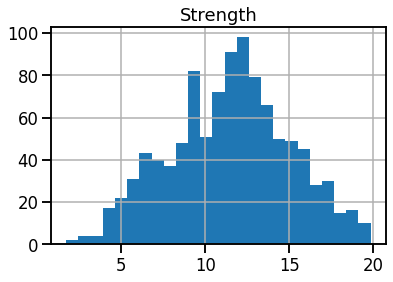

In [10]:
from scipy.stats import boxcox

# Transform target variable
y_boxcox, lambda_y = boxcox(y.apply(lambda x: x+1).values.ravel())
y_boxcox = pd.DataFrame(data=y_boxcox, columns=y.columns)
y_boxcox.hist(bins=25)

Cement 5.196738930698364e-27
Blast Furnace Slag 0.0
Fly Ash 0.0
Water 0.7240516770460926
Superplasticizer 0.0
Coarse Aggregate 7.351249206363798e-08
Fine Aggregate 0.797106986314958
Age 0.022558752399633515
Cement^2 5.950987676579039e-27
Cement Blast Furnace Slag 0.0
Cement Fly Ash 0.0
Cement Water 1.91939813570093e-23
Cement Superplasticizer 0.0
Cement Coarse Aggregate 0.0025654012631764916
Cement Fine Aggregate 4.613965799754541e-19
Cement Age 0.2556877859310001
Blast Furnace Slag^2 0.0
Blast Furnace Slag Fly Ash 7.744241399697571e-43
Blast Furnace Slag Water 0.0
Blast Furnace Slag Superplasticizer 0.0
Blast Furnace Slag Coarse Aggregate 0.0
Blast Furnace Slag Fine Aggregate 0.0
Blast Furnace Slag Age 0.0
Fly Ash^2 0.0
Fly Ash Water 0.0
Fly Ash Superplasticizer 0.0
Fly Ash Coarse Aggregate 0.0
Fly Ash Fine Aggregate 0.0
Fly Ash Age 0.0
Water^2 0.7238687869045308
Water Superplasticizer 0.0
Water Coarse Aggregate 0.0004116616361627877
Water Fine Aggregate 0.9654967954791539
Water Age 0

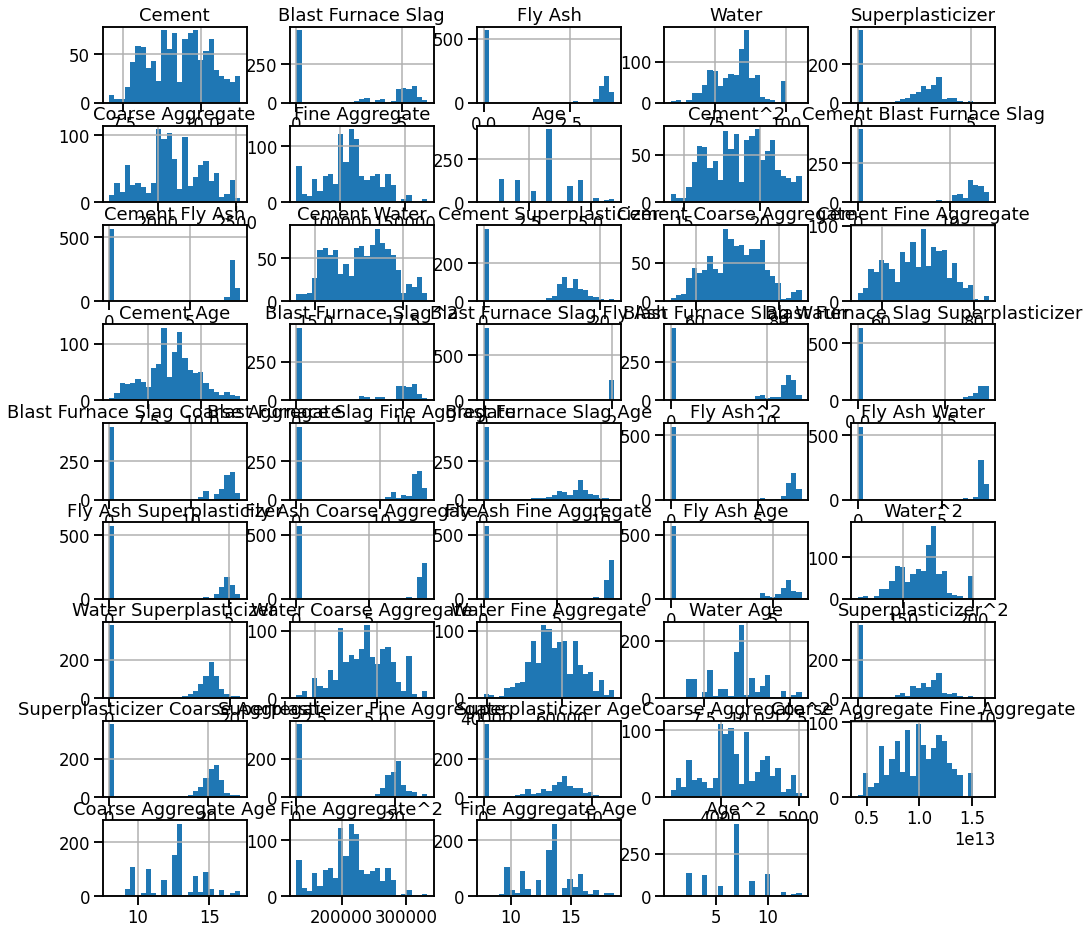

In [11]:
import numpy as np

# Transform independent variables
X_boxcox = []
lambda_X = []
for feature in X_poly.columns:
    x_boxcox, lambda_x = boxcox(X_poly[feature].apply(lambda x: x+1).values.ravel())
    lambda_X.append(lambda_x)
    X_boxcox.append(x_boxcox)

X_boxcox = pd.DataFrame(data=np.asarray(X_boxcox).T, columns=X_poly.columns)
X_boxcox.hist(bins=25, figsize=(16, 16), layout=(9, 5))

# Check normality after transformation
for feature in X_boxcox.columns:
    k, p = normaltest(getattr(X_boxcox, feature).values)
    print(feature, p)

As we observe, some variables cannot be transformed to follow the normal distribution. Thus, we use what we have.

## Standardization
We use standardization, to ensure that regularization is not affected by a variable scale.

array([[<AxesSubplot:title={'center':'Cement'}>,
        <AxesSubplot:title={'center':'Blast Furnace Slag'}>,
        <AxesSubplot:title={'center':'Fly Ash'}>,
        <AxesSubplot:title={'center':'Water'}>,
        <AxesSubplot:title={'center':'Superplasticizer'}>],
       [<AxesSubplot:title={'center':'Coarse Aggregate'}>,
        <AxesSubplot:title={'center':'Fine Aggregate'}>,
        <AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <Axe

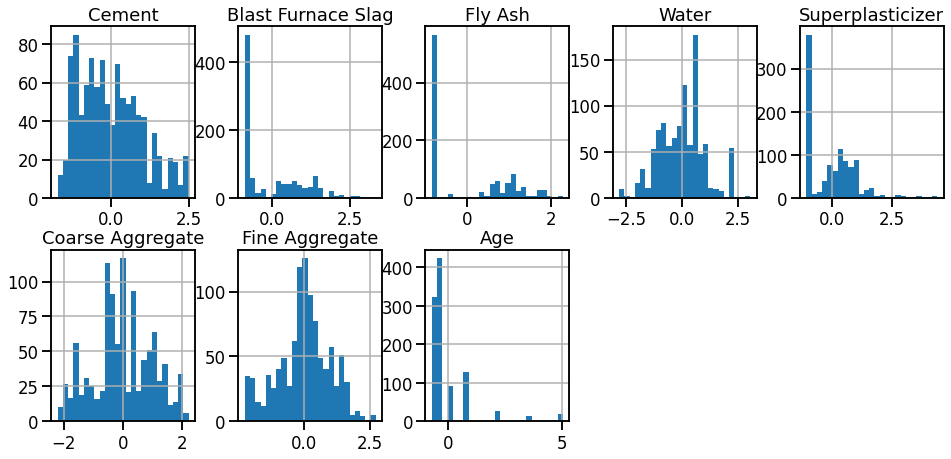

In [12]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X_ss = pd.DataFrame(s.fit_transform(X), columns=X.columns)
X_poly_ss = pd.DataFrame(s.fit_transform(X_boxcox), columns=X_boxcox.columns)
X_ss.hist(bins=25, figsize=(16, 36), layout=(9, 5))

# Training linear regression models

In this section, we train different linear regression models to select the one that predicts concrete strength with highest accuracy. To evaluate a performance, we use the mean of R$^2$ values obtained with 3-fold cross-validation method. We use R$^2$ score because it measures how much a model can explain the behavior of a target.

## Basic linear regression

Let us examine a basic linear regression model. We use only features that has been provided in the data set, without adding non-linear features. The data is scaled using standard scaling approach, although it is not expected to change the results qualitatively here. We obtain the coefficient of determination equal to 0.61.


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

scaler =  StandardScaler()

estimator = Pipeline([
    ("scaler", scaler),
    ("regression", LinearRegression())
])
kf = KFold(shuffle=True, random_state=72111, n_splits=3)
predictions = cross_val_predict(estimator, X, y, cv=kf)
r2_score(y, predictions)


0.6104386180185952

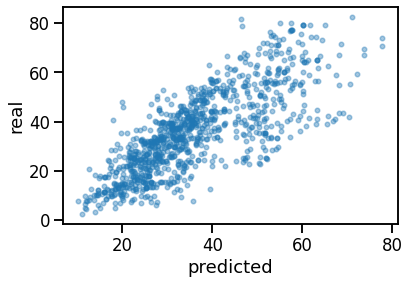

In [88]:
plt.figure(figsize=(6,4))
plt.scatter(predictions, y, marker='.', alpha=0.4)
plt.xlabel('predicted')
plt.ylabel('real');

Next, we examine if we can obtain higher R$^2$ score if we use polynomial features of second and third degree. We obtained R$^2$ equal to 0.7853172836053222 if we use second-degree polynonial features, and 0.830297235167918 if third-degree polynomial features are included. Although R$^2$ rises, suggesting that we decrease the bias, we can have the problem with overfitting. Thus, we need to examine models that introduce a penalty for high-value coefficients obtained from linear regression models.

In [89]:
# Linear regression with second degree polynomial features
predictions = cross_val_predict(estimator, X_poly, y, cv=kf)
r2_score(y, predictions)

0.7853172836053222

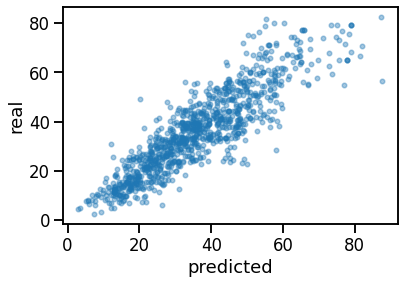

In [90]:
plt.figure(figsize=(6,4))
plt.scatter(predictions, y, marker='.', alpha=0.4)
plt.xlabel('predicted')
plt.ylabel('real');

In [91]:
# Linear regression with second third polynomial features
predictions = cross_val_predict(estimator, X_poly3, y, cv=kf)
r2_score(y, predictions)

0.830297235167918

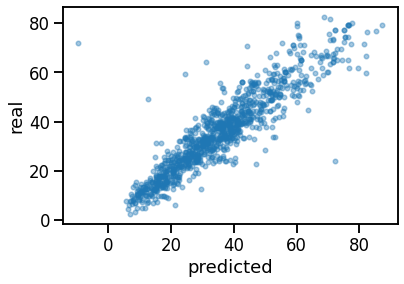

In [92]:
plt.figure(figsize=(6,4))
plt.scatter(predictions, y, marker='.', alpha=0.4)
plt.xlabel('predicted')
plt.ylabel('real');

## LASSO regression

The LASSO regression modifies a cost function by adding a penalty proportional to the absolute value of coefficients. It is tuned by the $\alpha$ parameter. We need to find the best regularization strength using cross-validation.

This model reduces many coefficients to zero, and thus, it can be used to exclude some features. The model becomes easier to interpret, but here we aim at predicting a strength of concrete, thus, we need to examine another approach, that is, Ridge regression.

In [49]:
# No polynomial features LASSO

alphas = np.geomspace(1e-9, 1e0, num=10)
scores = []

for alpha in alphas:

    estimator = Pipeline([
        ("scaler", scaler),
        ("lasso", Lasso(alpha=alpha, max_iter=100000))
    ])

    predictions = cross_val_predict(estimator, X, y, cv = kf)   
    score = r2_score(y, predictions) 
    scores.append(score)

alphas, max(scores)

(array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
        1.e-01, 1.e+00]),
 0.6104386180142576)

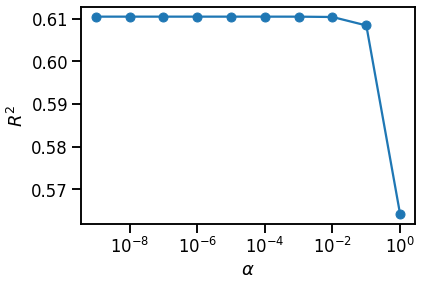

In [50]:
plt.figure(figsize=(6,4))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [47]:
# 2-order polynomial features LASSO

alphas = np.geomspace(1e-3, 1e0, num=20)
scores = []

for alpha in alphas:

    estimator = Pipeline([
        ("scaler", scaler),
        ("poly", PolynomialFeatures(degree=2)),
        ("lasso", Lasso(alpha=alpha, max_iter=200000))
    ])

    predictions = cross_val_predict(estimator, X, y, cv = kf)   
    score = r2_score(y, predictions) 
    scores.append(score)
alphas, max(scores)

(array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
        0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
        0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
        0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ]),
 0.7857554054527854)

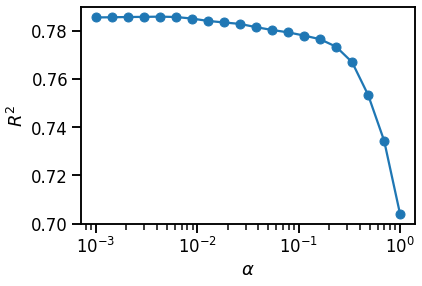

In [39]:
plt.figure(figsize=(6,4))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [66]:
# 3-order polynomial features LASSO

alphas = np.geomspace(1e-3, 1e0, num=20)
scores = []

for alpha in alphas:

    estimator = Pipeline([
        ("scaler", scaler),
        ("poly", PolynomialFeatures(degree=3)),
        ("lasso", Lasso(alpha=alpha, max_iter=200000))
    ])

    predictions = cross_val_predict(estimator, X, y, cv = kf)   
    score = r2_score(y, predictions) 
    scores.append(score)
alphas, max(scores)

(array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
        0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
        0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
        0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ]),
 0.8610798957009336)

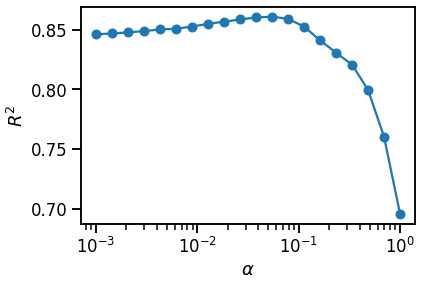

In [67]:
plt.figure(figsize=(6,4))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [94]:
# Best LASSO estimator (3-degree poly)

best_estimator = Pipeline([
                    ("scaler", scaler),
                    ("poly", PolynomialFeatures(degree=3)),
                    ("lasso", Lasso(alpha=0.05, max_iter=200000))])

best_estimator.fit(X, y)
print('Number of coeffients not equal to 0:', (best_estimator.named_steps["lasso"].coef_!=0).sum())
best_estimator.score(X, y)

Number of coeffients not equal to 0: 91


0.9031017566803472

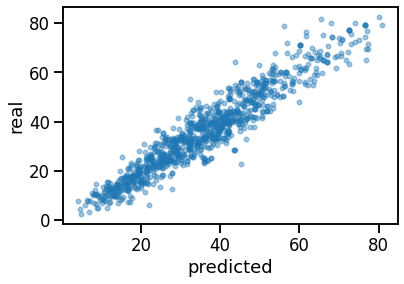

In [95]:
plt.figure(figsize=(6,4))
plt.scatter(best_estimator.predict(X), y, marker='.', alpha=0.4)
plt.xlabel('predicted')
plt.ylabel('real');

In [69]:
df_importances = pd.DataFrame(
    zip(
        best_estimator.named_steps["poly"].get_feature_names_out(),
        best_estimator.named_steps["lasso"].coef_,
    )
)
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))
df_importances.sort_values(by=1)

,0,1
44,x7^2,-15.159481
4,x3,-6.763004
154,x4 x7^2,-5.189929
35,x4^2,-3.326981
31,x3 x4,-2.293911
...,...,...
23,x1 x7,1.953589
91,x1 x2 x5,2.008217
2,x1,5.209482
1,x0,6.788437


In [46]:
# No polynomial features Ridge

alphas = np.geomspace(1e-9, 1e0, num=10)
scores = []

for alpha in alphas:

    estimator = Pipeline([
        ("scaler", scaler),
        ("lasso", Ridge(alpha=alpha, max_iter=100000))
    ])

    predictions = cross_val_predict(estimator, X, y, cv = kf)   
    score = r2_score(y, predictions) 
    scores.append(score)
alphas, max(scores)

(array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
        1.e-01, 1.e+00]),
 0.6104386180185768)

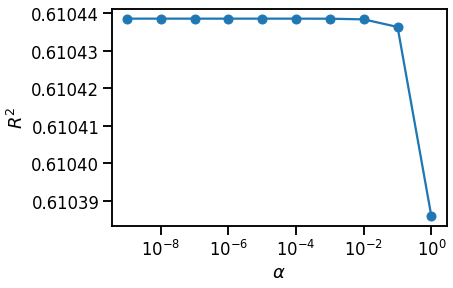

In [44]:
plt.figure(figsize=(6,4))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [45]:
# 2-order polynomial features Ridge

alphas = np.geomspace(1e-2, 1e0, num=20)
scores = []

for alpha in alphas:

    estimator = Pipeline([
        ("scaler", scaler),
        ("poly", PolynomialFeatures(degree=2)),
        ("lasso", Ridge(alpha=alpha, max_iter=200000))
    ])

    predictions = cross_val_predict(estimator, X, y, cv = kf)   
    score = r2_score(y, predictions) 
    scores.append(score)
    
alphas, max(scores)

(array([0.01      , 0.01274275, 0.01623777, 0.02069138, 0.02636651,
        0.03359818, 0.04281332, 0.05455595, 0.06951928, 0.08858668,
        0.11288379, 0.14384499, 0.18329807, 0.23357215, 0.29763514,
        0.37926902, 0.48329302, 0.61584821, 0.78475997, 1.        ]),
 0.7857829622219659)

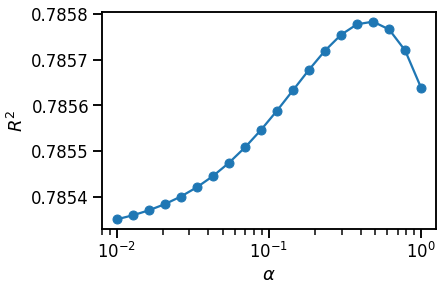

In [37]:
plt.figure(figsize=(6,4))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [74]:
# 3-order polynomial features Ridge

alphas = np.geomspace(1e0, 5e0, num=20)
scores = []

for alpha in alphas:

    estimator = Pipeline([
        ("scaler", scaler),
        ("poly", PolynomialFeatures(degree=3)),
        ("lasso", Ridge(alpha=alpha, max_iter=200000))
    ])

    predictions = cross_val_predict(estimator, X, y, cv = kf)   
    score = r2_score(y, predictions) 
    scores.append(score)
    
alphas, max(scores)

(array([1.        , 1.0883984 , 1.18461108, 1.2893288 , 1.40330341,
        1.52735318, 1.66236876, 1.8093195 , 1.96926045, 2.14333993,
        2.33280775, 2.53902423, 2.76346991, 3.00775623, 3.27363707,
        3.56302135, 3.87798674, 4.22079456, 4.59390605, 5.        ]),
 0.8556088267913762)

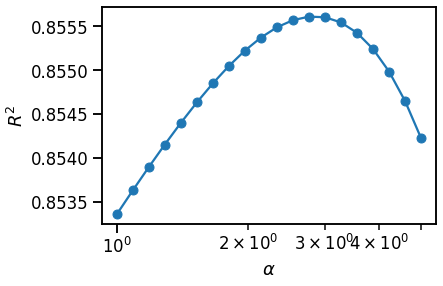

In [75]:
plt.figure(figsize=(6,4))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [76]:
# Best Ridge estimator (3-degree poly)

best_estimator = Pipeline([
                    ("scaler", scaler),
                    ("poly", PolynomialFeatures(degree=3)),
                    ("ridge", Ridge(alpha=3.1, max_iter=100000))])

best_estimator.fit(X, y)
print('Number of coeffients not equal to 0:', (best_estimator.named_steps["ridge"].coef_!=0).sum())
best_estimator.score(X, y)

Number of coeffients not equal to 0: 164


0.9177726053810777

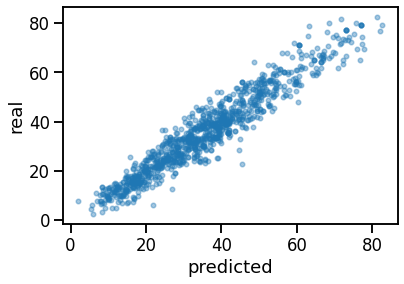

In [93]:
plt.figure(figsize=(6,4))
plt.scatter(best_estimator.predict(X), y, marker='.', alpha=0.4)
plt.xlabel('predicted')
plt.ylabel('real');

In [77]:
df_importances = pd.DataFrame(
    zip(
        best_estimator.named_steps["poly"].get_feature_names_out(),
        best_estimator.named_steps["ridge"].coef_,
    )
)
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))
df_importances.sort_values(by=1)

,0,1
0,1,"[0.0, 6.035681229617383, 3.6900914652595027, 0..."


## Selecting the best model

In this section, we trained three types of linear regression models -- the basic model, LASSO model, and Ridge model.  We used plain data with polynomial featuers of second and third degree, and no polynomial features as well. The data used in all models was standarized. Our purpose is to select the best model for predicting a strength of concrete. Thus, we aim at obtaining the best accuracy. We found out that Ridge model with $\alpha=3.1$ trained with data including third-order polymonial features provides the highest R$^2$ score. Thus, this is a model we recommend fro predicting a concrete strength.

# Key findings and insights

No coefficient is reduced to zero by a regularization process when only second-degree polynomial features are used. This observation suggests that a strengh of concrete depends on all substracts and interactions between them. Therefore, we expanded a model with polynomial features of third order. As the result, we obtained two models with R$^2$ score higher that 0.9.

Better insight into the reactions that occur in concrete is provided by LASSO model, which reduced a number of variables from 164 to 91. We observe strong non-linear relationship between a strength of concrete and its age. The young concrete gets harder and harder when time passes, but this trend reverses after maturing. Blast furnace slag and cement are key factors for a strengh of concrete, while adding too much water can severly damage the strength of concrete.

Our main goal is to evaluate the strength of concrete based on its composition and age, and thus, we select the model with best predictive power, that is a Ridge model with third-order polynomial features. It has a highest R$^2$ score equal to 0.92. No coefficient has been reduced by this model, but it is not a problem since our major goal is not the interpretation. With this model, the 0.92 of variance in the strength of concrete can be explained by its composition and age.

# Next steps

Our best model has the R$^2$ score equal to 0.92, which suggests that there are other factors that affect a strength of concrete. This agree well with the general knowledge on chemistry, as we know that chemical reactions can be influenced by details of process and external conditions. To obtain better accuracy, we need to know the temperature, air pressure, air humidity, and the order of operations performed while mixing the substracts. Also, the aging of concrete is affected by external conditions. The information on general climate features, that include information on minimal and maximal temperatures, and number of summy and rainy days in a year can help us with predicting a strength of concrete with high accuracy.